# Experiment 4.2.3: Gaussian Process Regression (5D)

This notebook evaluates the effectiveness of different point sets for Gaussian Process Regression (GPR) in 5D.

Uses optimal Korobov parameters from Table korobov_optimal_a.

## Setup

In [1]:
# Uncomment for Google Colab
# !pip install numpy scipy matplotlib qmcpy scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
from functools import reduce
from typing import List, Tuple, Optional, Callable
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn for GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

# Import from lattice_qmc package
from lattice_qmc import KorobovLattice, ExplicitRank1Lattice
from lattice_qmc.utils import generate_primes, compute_separation_radius_fast


# QMCPy for Halton and Sobol
try:
    import qmcpy as qp
    QMCPY_AVAILABLE = True
    print("QMCPy loaded successfully.")
except ImportError:
    QMCPY_AVAILABLE = False
    print("QMCPy not available.")

# Publication-quality plot settings
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.figsize': (10, 7),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

np.random.seed(42)
print("Setup complete!")

QMCPy loaded successfully.
Setup complete!


## Helper Functions for Other Point Sets

In [3]:
# ============================================================
# Other Point Set Generators
# ============================================================

def generate_random_points(n: int, d: int, seed: int = None) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)
    return np.random.rand(n, d)

def generate_halton_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required.")
    halton = qp.Halton(d, seed=42)
    return halton.gen_samples(n)

def generate_sobol_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required.")
    sobol = qp.Sobol(d, seed=42)
    return sobol.gen_samples(n)

print("Point set generators loaded.")

Point set generators loaded.


## Load Optimal Korobov Parameters

In [4]:
# Load optimal Korobov parameters from experiment 4.1.1
try:
    korobov_params = np.load('data/korobov_optimal_parameters.npy', allow_pickle=True).item()
    korobov_primes = korobov_params['primes']
    optimal_generators = korobov_params['optimal_generators']
    print("Loaded optimal Korobov parameters from file.")
    print(f"Available dimensions: {list(optimal_generators.keys())}")
    # Use the same Korobov primes and generators as in 04_01_03
    korobov_primes_5d = korobov_primes[2:8]
    korobov_generators_5d = optimal_generators[5][2:8] if optimal_generators is not None else None
    print(f"\nSelected primes for 5D: {korobov_primes_5d}")
    print(f"Optimal generators a* for d=5: {korobov_generators_5d}")
except FileNotFoundError:
    print("Warning: Could not load optimal parameters. Using default primes.")
    korobov_primes_5d = [13, 31, 61, 127, 251, 509, 1021]
    korobov_generators_5d = None
    optimal_generators = None

Loaded optimal Korobov parameters from file.
Available dimensions: [2, 3, 5, 7]

Selected primes for 5D: [ 13  31  61 127 251 509]
Optimal generators a* for d=5: [2, 2, 49, 82, 124, 20]


### 1.3 Pairwise Trigonometric Function

A function based on pairwise interactions between dimensions:

$$
f(x_1, \ldots, x_d) = \frac{2}{d(d-1)}\sum_{1 \leq i < j \leq d} \sin(\pi(x_i + x_j))
$$

This function captures pairwise dependencies and tests the ability of point sets to resolve interactions between variables.

In [5]:
def pairwise_trigonometric(X: np.ndarray) -> np.ndarray:
    """
    Pairwise trigonometric test function.

    f(x) = sum_{i<j} a_ij * sin(pi * x_i) * cos(pi * x_j)
    where a_ij = 1/(d*(d-1)/2) for normalization

    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, d) in [0, 1]^d.

    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    n, d = X.shape

    # Normalization constant: a_ij = 1/(d*(d-1)/2)
    num_pairs = d * (d - 1) // 2  # This is d*(d-1)/2
    a_ij = 1.0 / num_pairs          # This is 1/(d*(d-1)/2)

    result = np.zeros(n)

    for i in range(d):
        for j in range(i + 1, d):
            # CORRECTED: a_ij * sin(pi * x_i) * cos(pi * x_j)
            result += a_ij * np.sin(np.pi * X[:, i]) * np.cos(np.pi * X[:, j])

    return result


# Test
test_pts = np.array([[0.5]*5, [0.0]*5, [1.0]*5])
print("Pairwise Trigonometric function values:")
print(pairwise_trigonometric(test_pts))
print(f"\nFor d=5: a_ij = 1/(5*4/2) = 1/10 = {1.0/(5*4//2)}")

Pairwise Trigonometric function values:
[ 6.1232340e-17  0.0000000e+00 -1.2246468e-16]

For d=5: a_ij = 1/(5*4/2) = 1/10 = 0.1


---

## Part 2: GPR Implementation for 5D

In [6]:
def fit_gpr(X_train: np.ndarray, y_train: np.ndarray, 
            length_scale: float = 0.3, alpha: float = 1e-6) -> GaussianProcessRegressor:
    """
    Fit a Gaussian Process Regressor.
    """
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=length_scale, 
                                           length_scale_bounds=(1e-2, 1e1),
                                           nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, 
                                   n_restarts_optimizer=3,
                                   normalize_y=True)
    gpr.fit(X_train, y_train)
    return gpr


def compute_l2_error_mc(gpr: GaussianProcessRegressor, 
                        true_func: Callable,
                        d: int,
                        n_mc: int = 10000,
                        seed: int = 12345) -> float:
    """
    Compute L² error using Monte Carlo integration.
    
    For high dimensions, MC is more practical than tensor product quadrature.
    
    ||f - f_GPR||_{L²}² ≈ (1/n) Σ |f(x_i) - f_GPR(x_i)|²
    
    Parameters
    ----------
    gpr : GaussianProcessRegressor
        Fitted GPR model.
    true_func : Callable
        True function.
    d : int
        Dimension.
    n_mc : int
        Number of Monte Carlo samples.
    seed : int
        Random seed for reproducibility.
    
    Returns
    -------
    float
        Estimated L² error.
    """
    # Use pure Monte Carlo (random points)
    np.random.seed(seed)
    X_mc = np.random.rand(n_mc, d)
    
    # Evaluate
    f_true = true_func(X_mc)
    f_gpr = gpr.predict(X_mc)
    
    # L² error (MC estimate)
    l2_error_sq = np.mean((f_true - f_gpr)**2)
    return np.sqrt(l2_error_sq)


# Configuration for noisy observations
NOISE_STD = 0.05  # Standard deviation of observation noise
N_TRIALS = 100    # Number of Monte Carlo trials

print("GPR functions for 5D loaded.")
print(f"Noise std: {NOISE_STD}, Number of trials: {N_TRIALS}")

GPR functions for 5D loaded.
Noise std: 0.05, Number of trials: 100


---

## Part 3: Run Experiments

### 3.1 Configuration

In [7]:
d = 5

# Point counts for each method (use optimal parameters from data file)
# korobov_primes_5d and korobov_generators_5d are loaded above - DO NOT OVERRIDE!
explicit_m_by_d = {2: 7, 3: 12, 5: 10, 7: 5}  # from 04_01_03
explicit_m_5d = explicit_m_by_d[5]
explicit_m_values_5d = list(range(3, explicit_m_5d + 1))
powers = [16, 32, 64, 128, 256, 512]

print(f"Configuration for d = {d}:")
print(f"  Korobov primes (with optimal a*): {korobov_primes_5d}")
print(f"  Korobov generators: {korobov_generators_5d}")
print(f"  Explicit m values: {explicit_m_values_5d}")
print(f"  Powers for random/halton/sobol: {powers}")

Configuration for d = 5:
  Korobov primes (with optimal a*): [ 13  31  61 127 251 509]
  Korobov generators: [2, 2, 49, 82, 124, 20]
  Explicit m values: [3, 4, 5, 6, 7, 8, 9, 10]
  Powers for random/halton/sobol: [16, 32, 64, 128, 256, 512]


### 3.2 Run Experiment Function

In [8]:
def run_gpr_experiment_5d(test_func: Callable, func_name: str, n_trials: int = N_TRIALS):
    """
    Run GPR experiment for all point set types in 5D with noisy observations.
    Uses optimal Korobov generators when available.
    Each configuration is run n_trials times with different noise realizations.
    """
    results = {
        'korobov': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'explicit': {'N': [], 'l2_error_mean': [], 'l2_error_std': [], 'm': []},
        'random': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'halton': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'sobol': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
    }
    
    d = 5
    print(f"\n{'='*60}")
    print(f"GPR Experiment: {func_name} (d = {d})")
    print(f"Noise std: {NOISE_STD}, Trials: {n_trials}")
    print(f"{'='*60}")
    
    # Korobov lattices - use optimal generators
    print("\nKorobov lattices (using optimal generators from Table korobov_optimal_a):")
    for idx, N in enumerate(korobov_primes_5d):
        print(f"  N = {N}", end="")
        if korobov_generators_5d is not None:
            a_star = korobov_generators_5d[idx]
            print(f" (a*={a_star}): ", end="", flush=True)
            lattice = KorobovLattice(d=d, N=N, generator=a_star, verbose=False)
        else:
            print(": ", end="", flush=True)
            lattice = KorobovLattice(d=d, N=N, criterion="product", verbose=False)
        
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['korobov']['N'].append(N)
        results['korobov']['l2_error_mean'].append(np.mean(errors))
        results['korobov']['l2_error_std'].append(np.std(errors))
        print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Explicit rank-1 lattices
    print("\nExplicit rank-1 lattices (p=2):")
    p = 2
    alpha = np.array([p**(j/(d+1)) for j in range(1, d+1)])
    for m in explicit_m_values_5d:
        print(f"  m = {m}: ", end="", flush=True)
        lattice = ExplicitRank1Lattice(d=d, m=m, alpha=alpha, verbose=False)
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['explicit']['N'].append(lattice.Q)
        results['explicit']['l2_error_mean'].append(np.mean(errors))
        results['explicit']['l2_error_std'].append(np.std(errors))
        results['explicit']['m'].append(m)
        print(f"Q = {lattice.Q}, L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Random points
    print("\nRandom points:")
    for n in powers:
        print(f"  N = {n}: ", end="", flush=True)
        errors = []
        for trial in range(n_trials):
            np.random.seed(42 + trial)
            X_train = np.random.rand(n, d)
            y_true = test_func(X_train)
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['random']['N'].append(n)
        results['random']['l2_error_mean'].append(np.mean(errors))
        results['random']['l2_error_std'].append(np.std(errors))
        print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Halton
    if QMCPY_AVAILABLE:
        print("\nHalton sequence:")
        for n in powers:
            print(f"  N = {n}: ", end="", flush=True)
            X_train = generate_halton_points(n, d)
            y_true = test_func(X_train)
            
            errors = []
            for trial in range(n_trials):
                np.random.seed(1000 + trial)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error_mc(gpr, test_func, d=d)
                errors.append(l2_error)
            
            results['halton']['N'].append(n)
            results['halton']['l2_error_mean'].append(np.mean(errors))
            results['halton']['l2_error_std'].append(np.std(errors))
            print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
        
        # Sobol
        print("\nSobol sequence:")
        for n in powers:
            print(f"  N = {n}: ", end="", flush=True)
            X_train = generate_sobol_points(n, d)
            y_true = test_func(X_train)
            
            errors = []
            for trial in range(n_trials):
                np.random.seed(1000 + trial)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error_mc(gpr, test_func, d=d)
                errors.append(l2_error)
            
            results['sobol']['N'].append(n)
            results['sobol']['l2_error_mean'].append(np.mean(errors))
            results['sobol']['l2_error_std'].append(np.std(errors))
            print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    return results

### 3.3 Run Experiments for Each Test Function

In [9]:
# Experiment 3: Pairwise Trigonometric function
results_pairwise_trig = run_gpr_experiment_5d(pairwise_trigonometric, "Pairwise Trigonometric")


GPR Experiment: Pairwise Trigonometric (d = 5)
Noise std: 0.05, Trials: 100

Korobov lattices (using optimal generators from Table korobov_optimal_a):
  N = 13 (a*=2): L² = 7.905813e-02 ± 8.616611e-03
  N = 31 (a*=2): L² = 7.905813e-02 ± 8.616611e-03
  N = 31 (a*=2): L² = 6.875821e-02 ± 7.013104e-03
  N = 61 (a*=49): L² = 6.875821e-02 ± 7.013104e-03
  N = 61 (a*=49): L² = 5.706666e-02 ± 5.252968e-03
  N = 127 (a*=82): L² = 5.706666e-02 ± 5.252968e-03
  N = 127 (a*=82): L² = 4.531296e-02 ± 2.880465e-03
  N = 251 (a*=124): L² = 4.531296e-02 ± 2.880465e-03
  N = 251 (a*=124): L² = 4.349298e-02 ± 1.973326e-03
  N = 509 (a*=20): L² = 4.349298e-02 ± 1.973326e-03
  N = 509 (a*=20): L² = 4.028600e-02 ± 1.383482e-03

Explicit rank-1 lattices (p=2):
  m = 3: L² = 4.028600e-02 ± 1.383482e-03

Explicit rank-1 lattices (p=2):
  m = 3: Q = 15, L² = 1.521558e-01 ± 1.252891e-02
  m = 4: Q = 15, L² = 1.521558e-01 ± 1.252891e-02
  m = 4: Q = 24, L² = 1.446955e-01 ± 8.797613e-03
  m = 5: Q = 24, L² = 1.

---

## Part 4: Visualization

In [12]:
def plot_gpr_results(results: dict, d: int, func_name: str, save_fig: bool = True):
    """
    Plot L² error vs number of points with error bars.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    
    styles = {
        'korobov': {'color': '#1f77b4', 'marker': 'o', 'label': 'Korobov (ours)'},
        'explicit': {'color': '#d62728', 'marker': 's', 'label': 'Explicit (ours)'},
        'random': {'color': '#7f7f7f', 'marker': 'x', 'label': 'Random'},
        'halton': {'color': '#2ca02c', 'marker': '^', 'label': 'Halton'},
        'sobol': {'color': '#9467bd', 'marker': 'D', 'label': 'Sobol'},
    }
    
    for method, style in styles.items():
        if results[method]['N']:
            N = np.array(results[method]['N'])
            mean = np.array(results[method]['l2_error_mean'])
            std = np.array(results[method]['l2_error_std'])
            
            ax.errorbar(N, mean, yerr=std, 
                       marker=style['marker'], color=style['color'],
                       label=style['label'], linewidth=2, markersize=10,
                       capsize=3, capthick=1)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of points $N$')
    ax.set_ylabel('$L^2$ error')
    # ax.set_title(f'GPR Approximation Error ({func_name}, $d = {d}$)\nNoise $\\sigma = {NOISE_STD}$, {N_TRIALS} trials')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    
    if save_fig:
        filename = f'gpr_error_{func_name.lower().replace(" ", "_")}_{d}d'
        plt.savefig(f'{filename}.pdf')
        plt.savefig(f'{filename}.png', dpi=300)
        print(f"Saved: {filename}.pdf, {filename}.png")
    
    plt.show()

Saved: gpr_error_pairwise_trigonometric_5d.pdf, gpr_error_pairwise_trigonometric_5d.png


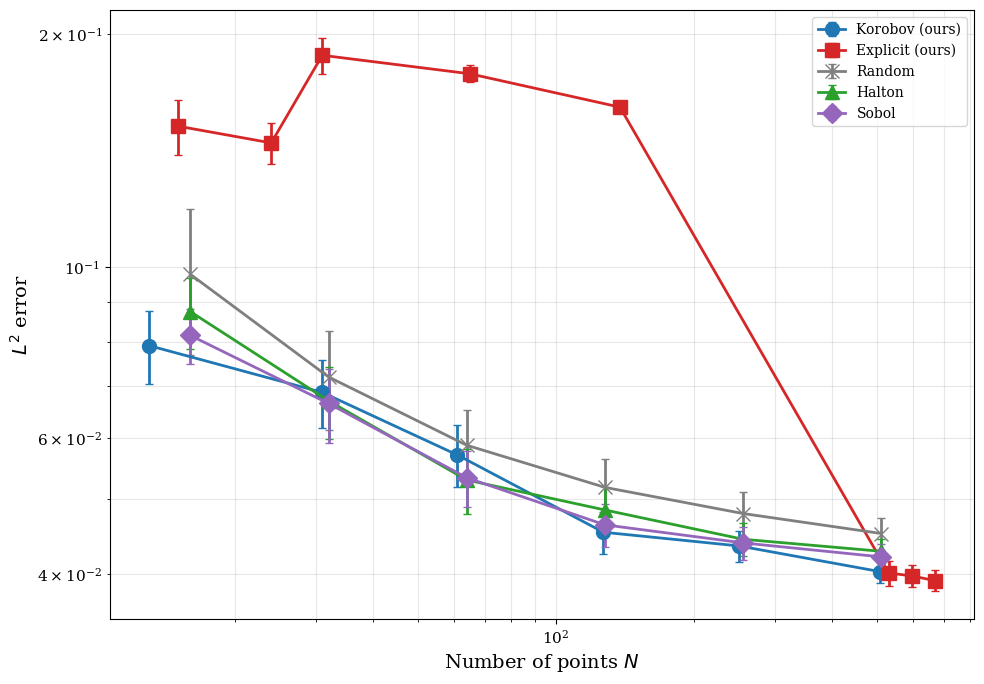

In [13]:
# Plot Pairwise Trigonometric results
plot_gpr_results(results_pairwise_trig, d=5, func_name="Pairwise Trigonometric")